In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import re

import matplotlib.pyplot as plt

## The following datasets are sourced from these websites, unless otherwise stated:
https://www.gate.ezv.admin.ch/swissimpex/index.xhtml Swiss Impex, for import data

https://www.sbv-usp.ch/fr/service/statistiques/ Swiss Farmers Union, for various agricultural data

## Main question driving the project: How can a Swiss consumer, based on all the factors that go into the carbon emissions of food production, best adapt their diet to reduce their carbon foodprint?

As is slowly becoming a widely-known fact, the meat and animal product industry is significantly more carbon-intensive than plant-based foods. The amount of CO2 produced per kg (or even kcal) of meat/animal product is much higher than the amount of CO2 for the same mass/energy equivalent of plants (e.g. fruits, vegetables, legumes). One might think, then, that the best way to reduce one's "carbon foodprint" (carbon footprint due to food production) is to take on a vegetarian or vegan diet.

What is intriguing is that this may not be the answer in all cases. Based on where food is sourced, what time of year it is grown, and how it is produced, the carbon emissions can change drastically. A hot house tomato grown out of season can produce less carbon than pasture-fed goat meat, for example. 

An important question that data can answer, then, is how an eco-friendly citizen can best adapt their diet, based on their specific living circumstances, to reduce their carbon foodprint. Here, we will perform an in-depth analysis on Switzerland, providing a consumer with the knowledge necessary to produce less carbon emissions due to their diet. This will include an analysis of carbon intensities by food type and the various types and sources of food that are imported into Switzerland. After all, since Switzerland has a fairly dense population for its small size, it imports a significant amount of its food:

"According to the Federal Agriculture Office, Switzerland’s gross self-sufficiency rate in 2015 was 59%. The degree of self-sufficiency is defined as the ratio of domestic production to total domestic consumption. With imported animal feed taken into account, the net level of self-sufficiency was 51% that year.

But a closer look at the data reveals major differences across products. The country has been able to produce almost 100% of its animal foodstuffs for years, yet has managed only about 40% self-sufficiency for plant-based foods, a rate that fluctuates year on year as harvests are highly weather-dependent." (From swissinfo.ch)

Depending on where and what types of food Switzerland is importing its non-meat food products from, this raises the possibility that a Swiss citizen might have a smaller carbon foodprint by eating more meat, contradicting the typical recommendation. Would living with a vegan diet require an excessive amount of imported foods, outweighting the carbon offset of not eating meat? Or is there a large enough amount of imported livestock feed that eating a plant-based diet is still more sustainable? 

Let's start by looking at Swiss food imports on a macro scale.

In [7]:
# this sheet is food, beverages, and tobacco
imported_goods = pd.read_excel('../data/nature-of-goods-imports.xlsx', skiprows=5, sheet_name='01.1')
imported_goods.dropna(how='all',inplace=True)
imported_goods.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True) #empty columns
imported_goods.rename({'Unnamed: 0':'Year', 'Unnamed: 1':'Commercial Partner'}, inplace=True, axis=1)
imported_goods['Commercial Partner'] = imported_goods['Commercial Partner'].str.strip() # get rid of leading whitespace
imported_goods.head()

,Year,Commercial Partner,Quantity (kg),Value (CHF),Value +/- %
0,2017,Total trade,4.125947e+09,1.058994e+10,4.5
1,2017,Afghanistan,3.300000e+01,1.229620e+05,244.1
2,2017,Albania,3.444010e+05,3.499380e+05,-26.7
3,2017,Algeria,9.049800e+04,4.043350e+05,0.1
4,2017,Amer. Virgin,5.000000e+01,2.793000e+03,-90.6


Let's look at how much of the food, beverages, and tobacco that Switzerland imports comes from its nearest neighboring countries. The farther a country is, the more carbon emissions it would cost to import that food.

In [8]:
# I just hand-wrote this list, it doesn't actually mean anything. Just picked nearby countries
nearby_countries = ['Portugal', 'Spain', 'France', 'Germany', 'Italy', 'Austria', 'Belgium', 'Netherlands', 'Czech Republic', 'Slovenia', 'Croatia']
imported_goods_nearby = imported_goods[imported_goods['Commercial Partner'].isin(nearby_countries)].copy()
imported_goods_nearby.head()

,Year,Commercial Partner,Quantity (kg),Value (CHF),Value +/- %
10,2017,Austria,205839135.0,3.633062e+08,11.3
17,2017,Belgium,53206197.0,1.654063e+08,2.1
44,2017,Croatia,1937165.0,7.261209e+06,18.4
48,2017,Czech Republic,62643717.0,4.549908e+07,16.5
63,2017,France,625539021.0,1.281604e+09,3.6


In [9]:
total_nearby_imported = imported_goods_nearby['Quantity (kg)'].sum()
100*total_nearby_imported/imported_goods.iloc[0][2]

74.21443433630381

Approximately 74% of Switzerland's imported food, beverage, and tobacco products come from fairly nearby countries. That's pretty good! It means imports would have a lower carbon output than if Switzerland imported a lot from far away. (It does not, however, indicate anything to us about whether the countries that Switzerland sources its imports from are carbon efficient. For example, Germany might have higher carbon intensities per kilo of wheat produced than the same product in France.) 

What about Switzerland's imported feedstuffs for animals? (If the Swiss import a lot of feed, that contributes to an even higher carbon intensity for raising meat)

In [10]:
# this sheet is feeding stuffs for animals
imported_feed = pd.read_excel('../data/nature-of-goods-imports.xlsx', skiprows=5, sheet_name='01.2')
imported_feed.dropna(how='all',inplace=True)
imported_feed.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True) #empty columns
imported_feed.rename({'Unnamed: 0':'Year', 'Unnamed: 1':'Commercial Partner'}, inplace=True, axis=1)
imported_feed['Commercial Partner'] = imported_feed['Commercial Partner'].str.strip() # get rid of leading whitespace
imported_feed.head()

,Year,Commercial Partner,Quantity (kg),Value (CHF),Value +/- %
0,2017,Total trade,1.805791e+09,790556375.0,5
1,2017,Albania,7.400000e+01,857.0,26.6
2,2017,Argentina,1.153685e+06,396099.0,268.2
3,2017,Australia,5.040000e+02,1627.0,-88.5
4,2017,Austria,1.028771e+08,40044159.0,17.3


In [11]:
imported_feed_nearby = imported_feed[imported_feed['Commercial Partner'].isin(nearby_countries)].copy()
total_nearby_imported_feed = imported_feed_nearby['Quantity (kg)'].sum()
100*total_nearby_imported_feed/imported_feed.iloc[0][2]

73.97204548162978

Nearly three-quarters of imported animal feed is imported from nearby countries, which means when Switzerland must import feed, they mostly minimize carbon emissions from the process by reducing the travel distance of the feed. More importantly, a report from the State Secretariat for Economic Affairs ("Concentrate Animal Feed as an Input Good in Swiss Agricultural Production - The Effects of Border Protection and Other Support Measures") claims 90% of animal feed used in Switzerland is domestically produced, drastically reducing the carbon impact of the meat industry in the country.

This percentage can be found in this PDF document (see the table on page 8):

https://www.sbv-usp.ch/fileadmin/sbvuspch/00_Bilder/06_Services/Agristat/Statistiken/Produktionsmittel__Umwelt/SES2018_Kap04_Produktionsmittel-Umwelt.pdf

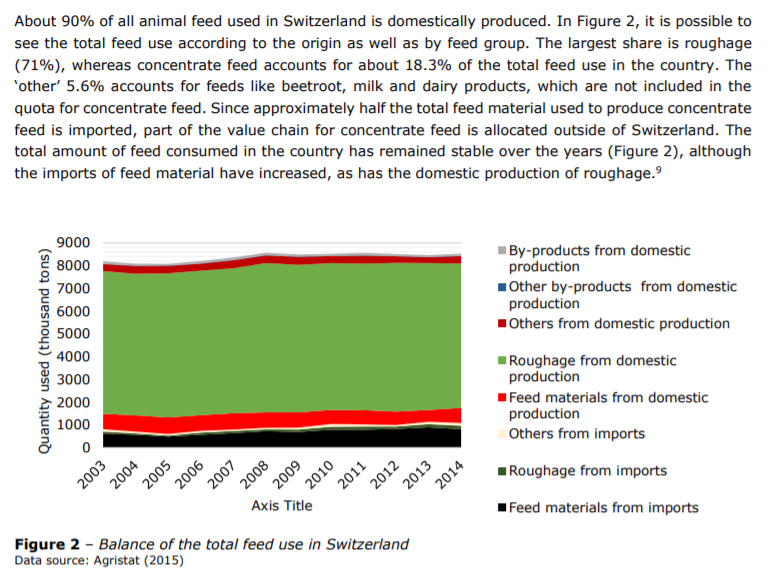

In [21]:
# the following image is from the Concentrate Animal Feed report
# it gives a good idea of what we should see in the data about imported/domestically produced feed
from IPython.display import Image
Image('swiss_feed_by_origin.png', width=800,height=600)

We will need to pay attention to where food is coming from by animal type. For example, 90% of cow and cattle feed is domestically produced, whereas that number is only 52% for pork and 30% for poultry (found in the Concentrate Animal Feed report above, where it was sourced from the PDF linked above). So even if chickens are less carbon intensive, they require more imported feed which might increase their carbon output!

Let's now look at how much meat Switzerland imports.

In [ ]:
# should download this data for 2017 instead to match swiss emissions and consumption data
# "selected" meat imports since there is way more detail available, I just didn't download it
meat_imported = pd.read_excel('../data/selected-meat-imports.xlsx', skiprows=5, sheet_name='02')
meat_imported.dropna(how='all',inplace=True)
meat_imported.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True)
meat_imported.rename({'Unnamed: 0':'Year', 'Unnamed: 1':'Commercial Partner'}, inplace=True, axis=1)
meat_imported.head()

As we can see from the above table, Switzerland imported 77 million kg of meat and edible offal in 2018 (equivalent to 77 thousand tonnes). The breakdowns by country are also provided.

Now let's look at what Switzerland's population _consumes_. 

In [ ]:
# Note: all of these values are from 2017 (earlier years are also available)
food_consumption_types = pd.read_excel(r'../data/food_consumption_by_type_of_food.xlsx', skiprows=8)
food_consumption_types.dropna(inplace=True)
food_consumption_types.rename({'1000 t':'Quantity, total, 1000 tonnes', 'kg ':'Quantity, kg/person/year', ' t':'Protein, total, tonnes', 'g':'Protein, g/person/day', '%':'Protein, % indigenous production', 'TJ':'Energy intake, total, TJ', 'KJ':'Energy intake, kj/person/day', '%.1':'Energy intake, % indigenous production'}, inplace=True, axis=1)
food_consumption_types.head()

Specifically, let's look at meat from the above table. How much meat did Swiss people consume in 2017?

In [ ]:
food_consumption_types.iloc[17]

As can be seen, the Swiss consumed 413 thousand tonnes, but they imported 77 thousand tonnes. This means most of the Swiss meat is produced within the country. (This calculates to be 81% of consumed Swiss meat to be domestically produced/non-imported)

Some other important facts, as provided by an article on swissinfo.ch: Switzerland produces more than enough milk and milk products to satisfy its needs, but has to import the majority of its fruits, vegetables, and nuts. Animal feed is one of the major imports, as well as staples like rice and wheat.

##### How does this affect emissions?
The next thing we can look at is how intensive (in terms of carbon emissions) it is for Switzerland to produce certain types of food.

In [ ]:
# this data is from FAO, emissions intensities
swiss_emis = pd.read_csv(r'../data/swiss_emissions_intensities.csv')
swiss_emis = swiss_emis[swiss_emis['Unit'] == 'kg CO2eq/kg product']
swiss_emis

# Where Brooke sees this going from here
Next, we'd have to look at what types of food Switzerland typically imports from other countries, then look at the emissions intensities for those foods in those countries. See notes in the last cell about the typical Swiss diet.

I don't know how we're going to approach calculating emissions for imported animals and meat (meaning, also including the carbon emissions of transport). I haven't thought about/researched that yet.

The data from Swiss-Impex (linked in the top of the notebook) is extremely detailed and has a lot more information to give. Feel free to check it out and get a sense of other data that we could use from there.

Points of discussion, which we can mention/speculate on but which our analysis will _not_ be able to address:

* Animals often are fed with by-products of human food production. If people eat less meat/animal products, we will have more food waste to dispose of

Perhaps we don't need a dataset about Swiss eating habits? (menuCH study data is restricted)
We should probably just look at carbon emissions of the normal recommended diet
Then we can pull some metadata of menuCH (Swiss consumption habits) from a report I found (e.g. "The Swiss population consumes an average of 220 g milk and dairy products such as cheese and yoghurt per person per day, which equates to 2 portions. They eat 150 g of other protein-based food such as meat, fish and tofu per day, of which 110 g comes from meat and meat products alone.")

Advice from Akhil (TA): At the very beginning, state all assumptions and justify them (one major assumption: we are assuming the given situation in Swiss agriculture and economics. We are NOT considering what the government can do (e.g. altering crops produced for exports, etc). Only what a consumer can do in the given situation)